In [ ]:
!pip install -r requirements.txt

In [ ]:
!pip install torchvision --upgrade

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import re
from sklearn.preprocessing import LabelEncoder
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, AutoTokenizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import DataCollatorWithPadding
import numpy as np
import pandas as pd
import re
import evaluate

In [7]:
import torch
print(torch.cuda.is_available())

True


In [9]:
data = pd.read_csv("/content/sms_scam_detection_dataset_merged_with_lang.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138813 entries, 0 to 138812
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   label        138813 non-null  object 
 1   text         138812 non-null  object 
 2   URL          5949 non-null    object 
 3   EMAIL        5949 non-null    object 
 4   PHONE        5949 non-null    object 
 5   lang         21569 non-null   object 
 6   Unnamed: 6   10491 non-null   object 
 7   Unnamed: 7   114496 non-null  float64
 8   Unnamed: 8   43 non-null      object 
 9   Unnamed: 9   10 non-null      object 
 10  Unnamed: 10  5 non-null       object 
dtypes: float64(1), object(10)
memory usage: 11.6+ MB


<ipython-input-9-c13275a3086b>:1: DtypeWarning: Columns (2,3,4,5,6,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("/content/sms_scam_detection_dataset_merged_with_lang.csv")


In [10]:
label_counts = data['lang'].value_counts()

print(label_counts)

lang
en         5850
hindi      5129
french     5108
german     5108
english     275
und          13
hi            8
ml            8
nl            7
no            6
ro            5
kn            5
ta            4
kha           4
ru            3
te            3
bn            3
es            3
pt            2
ar            2
lb            2
zh            2
it            1
af            1
ms            1
ht            1
ku            1
fr            1
sv            1
fil           1
aa            1
sw            1
ny            1
pl            1
vi            1
hr            1
tr            1
sm            1
fy            1
gu            1
kri           1
Name: count, dtype: int64


In [11]:
# Filter the rows where 'lang' is either 'en' or 'english'
data = data[data['lang'].isin(['en', 'english'])]

print(data)

      label                                               text  URL EMAIL  \
0       ham  Your opinion about me? 1. Over 2. Jada 3. Kusr...   No    No   
1       ham  What's up? Do you want me to come online? If y...   No    No   
2       ham                       So u workin overtime nigpun?   No    No   
3       ham  Also sir, i sent you an email about how to log...   No    No   
4      spam  Please Stay At Home. To encourage the notion o...   No    No   
...     ...                                                ...  ...   ...   
21245   ham             Ü predict wat time ü'll finish buying?  NaN   NaN   
21334   ham  Our Prashanthettan's mother passed away last n...  NaN   NaN   
21404   ham  That way transport is less problematic than on...  NaN   NaN   
21552   ham                       I sent you  &lt;#&gt;  bucks  NaN   NaN   
21554  spam  Win the newest Harry Potter and the Order of ...  NaN   NaN   

      PHONE     lang Unnamed: 6  Unnamed: 7 Unnamed: 8 Unnamed: 9 Unnamed: 

In [12]:
to_drop = ["URL","EMAIL","PHONE","lang","Unnamed: 6","Unnamed: 7","Unnamed: 8","Unnamed: 9","Unnamed: 10"]
data = data.drop(data[to_drop], axis=1)

data.head()

,label,text
0,ham,Your opinion about me? 1. Over 2. Jada 3. Kusr...
1,ham,What's up? Do you want me to come online? If y...
2,ham,So u workin overtime nigpun?
3,ham,"Also sir, i sent you an email about how to log..."
4,spam,Please Stay At Home. To encourage the notion o...


In [13]:
data['label'] = data['label'].replace({'ham': 'Legitimate', 'spam': 'Scam', 'Spam': 'Scam'})

label_counts = data['label'].value_counts()
print(label_counts)

label
Legitimate    4934
Scam          1191
Name: count, dtype: int64


<ipython-input-14-14b3ea73e895>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x='label', palette='Set2')


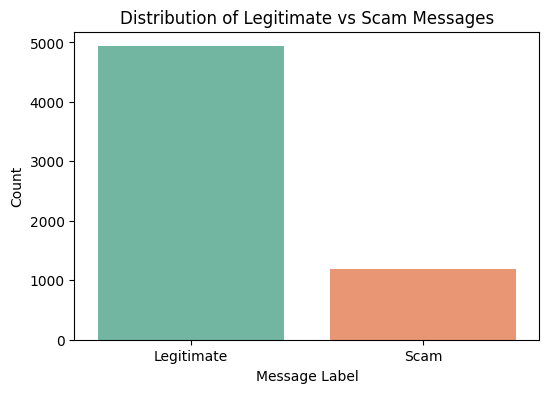

In [14]:
plt.figure(figsize=(6, 4))
sns.countplot(data=data, x='label', palette='Set2')

plt.title('Distribution of Legitimate vs Scam Messages')
plt.xlabel('Message Label')
plt.ylabel('Count')

plt.show()

In [15]:
# Separate the classes
legitimate = data[data['label'] == 'Legitimate']
scam =  data[data['label'] == 'Scam']

# Downsample Legitimate to match the size of Scam
legitimate_downsampled = legitimate.sample(n=len(scam), random_state=42)

data = pd.concat([legitimate_downsampled, scam])
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

print(data['label'].value_counts())


label
Scam          1191
Legitimate    1191
Name: count, dtype: int64


In [16]:
data.shape

(2382, 2)

In [21]:
# Check how many null values are in the 'text' and 'label' column
text_null_count = data['text'].isnull().sum()
label_null_count = data['label'].isnull().sum()
print(f"Number of null values in 'text' column: {text_null_count}")
print(f"Number of null values in 'label' column: {label_null_count}")

Number of null values in 'text' column: 0
Number of null values in 'label' column: 0


In [23]:
data['count'] = data['text'].apply(lambda x: len(x.split()))
data.head()

,label,text,count
0,Scam,Sunshine Hols. To claim ur med holiday send a ...,27
1,Scam,price revising soon for urbtech xaviers fully ...,20
2,Legitimate,Hi dude hw r u da realy mising u today,10
3,Scam,\tURGENT. Important information for 02 user. T...,27
4,Scam,Promotion Number: 8714714 - UR awarded a City ...,16


In [24]:
print(data['count'].describe())

count    2382.000000
mean       18.669186
std         9.779924
min         1.000000
25%        10.000000
50%        20.000000
75%        25.000000
max        96.000000
Name: count, dtype: float64


<Figure size 800x800 with 0 Axes>

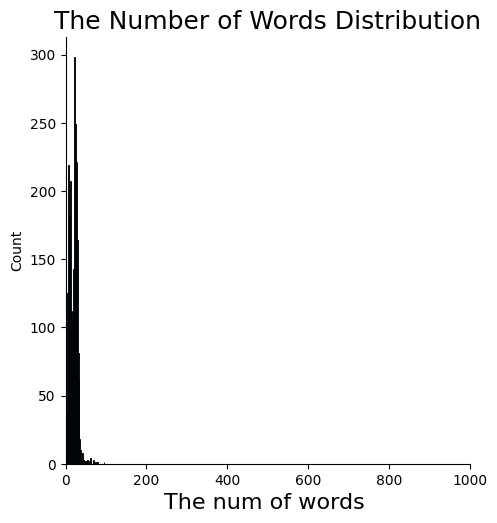

In [25]:
plt.figure(figsize= (8, 8))

sns.displot(data['count'])

plt.xlim(0, 1000)

plt.xlabel('The num of words ', fontsize = 16)
plt.title("The Number of Words Distribution", fontsize = 18)
plt.show()

In [26]:
Q1 = data['count'].quantile(0.25)
Q3 = data['count'].quantile(0.75)

IQR = Q3 - Q1

lower_bound = max(0, Q1 - 1.5 * IQR)
upper_bound = Q3 + 1.5 * IQR

print(f"Lower bound for outliers: {lower_bound}")
print(f"Upper bound for outliers: {upper_bound}")


Lower bound for outliers: 0
Upper bound for outliers: 47.5


In [27]:
short_texts = data[data['count'] > upper_bound]

num_short_texts = short_texts.shape[0]

print(f"Number of texts with {upper_bound} words or fewer: {num_short_texts}")
print(short_texts.head(5))


Number of texts with 47.5 words or fewer: 21
          label                                               text  count
71         Scam  IMPORTANT MESSAGE FROM WESTPAC For the safety ...     51
80   Legitimate  I was wondering if it would be okay for you to...     69
157  Legitimate  Do whatever you want. You know what the rules ...     68
297        Scam  GOV.UK ALERT CORONAVIRUS It has come to our at...     68
379  Legitimate  She is our sister.. She belongs 2 our family.....     54


In [28]:
# Filter out the outliers based on the 'count' column
filtered_df = data[(data['count'] >= lower_bound) & (data['count'] <= upper_bound)]

print(f"Original dataset size: {data.shape[0]}")
print(f"Dataset size after removing outliers: {filtered_df.shape[0]}")

Original dataset size: 2382
Dataset size after removing outliers: 2361


In [29]:
label_counts = filtered_df['label'].value_counts()

print(label_counts)

label
Scam          1187
Legitimate    1174
Name: count, dtype: int64


In [30]:
filtered_df.head(5)

,label,text,count
0,Scam,Sunshine Hols. To claim ur med holiday send a ...,27
1,Scam,price revising soon for urbtech xaviers fully ...,20
2,Legitimate,Hi dude hw r u da realy mising u today,10
3,Scam,\tURGENT. Important information for 02 user. T...,27
4,Scam,Promotion Number: 8714714 - UR awarded a City ...,16


In [31]:
# Data Cleaning
def clean_text(text):
    text = re.sub(r'http\S+', ' ', text)  # Remove URLs
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)  # Remove non-alphabetic characters
    text = text.lower().strip()  # Convert to lowercase and remove extra spaces
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    return text

filtered_df["Clean_Text"] = filtered_df["text"].apply(clean_text)

# Label Encoding
label_encoder = LabelEncoder()
filtered_df["Encoded_Label"] = label_encoder.fit_transform(filtered_df["label"])

<ipython-input-31-681525a5fbb0>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["Clean_Text"] = filtered_df["text"].apply(clean_text)
<ipython-input-31-681525a5fbb0>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["Encoded_Label"] = label_encoder.fit_transform(filtered_df["label"])


In [33]:
from datasets import Dataset

# DistilBERT's tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=512)

# Split Dataset train-test-val split (80%-16%-4%)
train_texts, test_texts, train_labels, test_labels = train_test_split(
    filtered_df["Clean_Text"], filtered_df["Encoded_Label"], test_size=0.2, random_state=42
)

train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_texts, train_labels, test_size=0.2, random_state=42
)
1
train_dataset = pd.DataFrame({"text": train_texts, "label": train_labels}).reset_index(drop=True)
val_dataset = pd.DataFrame({"text": val_texts, "label": val_labels}).reset_index(drop=True)
test_dataset = pd.DataFrame({"text": test_texts, "label": test_labels}).reset_index(drop=True)

train_dataset = Dataset.from_pandas(train_dataset)
val_dataset = Dataset.from_pandas(val_dataset)
test_dataset = Dataset.from_pandas(test_dataset)

# Tokenization
train_tokenized = train_dataset.map(preprocess_function, batched=True)
val_tokenized = val_dataset.map(preprocess_function, batched=True)
test_tokenized = test_dataset.map(preprocess_function, batched=True)

# Padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)


id2label = {0: "Legitimate", 1: "Scam"}
label2id = {"Legitimate": 0, "Scam": 1}

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=2, id2label=id2label, label2id=label2id
)


Map:   0%|          | 0/1510 [00:00<?, ? examples/s]

Map:   0%|          | 0/378 [00:00<?, ? examples/s]

Map:   0%|          | 0/473 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [36]:
training_args = TrainingArguments(
    output_dir="scam_detect",
    learning_rate=1e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False,
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [35]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=val_tokenized,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

test_results = trainer.evaluate(test_tokenized)
print(f"Test results: {test_results}")

trainer.save_model("scam_detect")

print("Fine tuning completed")

<ipython-input-35-cb69d1798588>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: muhdhazimz10 (muhdhazimz10-personal) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.110562,0.965608
2,No log,0.083348,0.976190
3,No log,0.072231,0.981481
4,No log,0.075377,0.978836
5,No log,0.074898,0.978836
6,0.099100,0.077896,0.981481
7,0.099100,0.076335,0.981481
8,0.099100,0.084145,0.976190
9,0.099100,0.084791,0.978836
10,0.099100,0.082924,0.978836


Test results: {'eval_loss': 0.08715152740478516, 'eval_accuracy': 0.9767441860465116, 'eval_runtime': 6.9773, 'eval_samples_per_second': 67.791, 'eval_steps_per_second': 4.3, 'epoch': 10.0}
Fine tuning completed


              precision    recall  f1-score   support

        Scam       0.97      0.98      0.98       219
  Legitimate       0.98      0.98      0.98       254

    accuracy                           0.98       473
   macro avg       0.98      0.98      0.98       473
weighted avg       0.98      0.98      0.98       473



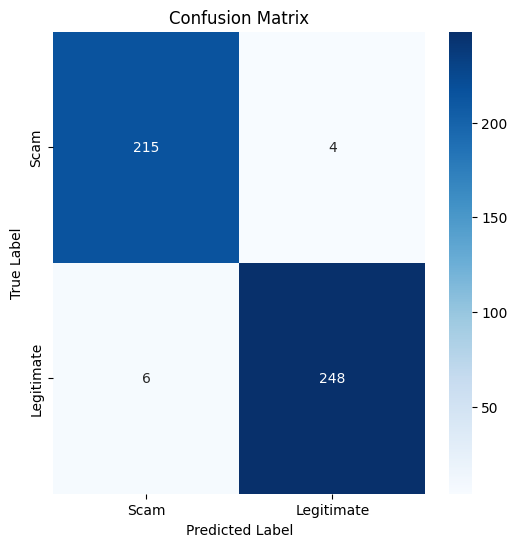

In [64]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

predictions, label_ids, metrics = trainer.predict(test_tokenized)

pred_labels = np.argmax(predictions, axis=1)
true_labels = label_ids

report = classification_report(true_labels, pred_labels, target_names=["Scam", "Legitimate"])
print(report)

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Scam", "Legitimate"], yticklabels=["Scam", "Legitimate"])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()


In [38]:
training_args = TrainingArguments(
    output_dir="scam_detect_v2",
    learning_rate=1e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False,
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [40]:
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback

early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=2
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=val_tokenized,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping_callback],
)

trainer.train()

test_results = trainer.evaluate(test_tokenized)
print(f"Test results: {test_results}")

trainer.save_model("scam_detect_v2")

print("Fine tuning completed")

<ipython-input-40-0a8c608d7646>:7: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.078630,0.978836
2,No log,0.088824,0.978836
3,No log,0.075922,0.981481
4,No log,0.080448,0.981481
5,No log,0.083973,0.978836


Test results: {'eval_loss': 0.10183283686637878, 'eval_accuracy': 0.9809725158562368, 'eval_runtime': 6.9342, 'eval_samples_per_second': 68.213, 'eval_steps_per_second': 4.326, 'epoch': 5.0}
Fine tuning completed


              precision    recall  f1-score   support

        Scam       0.97      0.99      0.98       219
  Legitimate       0.99      0.98      0.98       254

    accuracy                           0.98       473
   macro avg       0.98      0.98      0.98       473
weighted avg       0.98      0.98      0.98       473



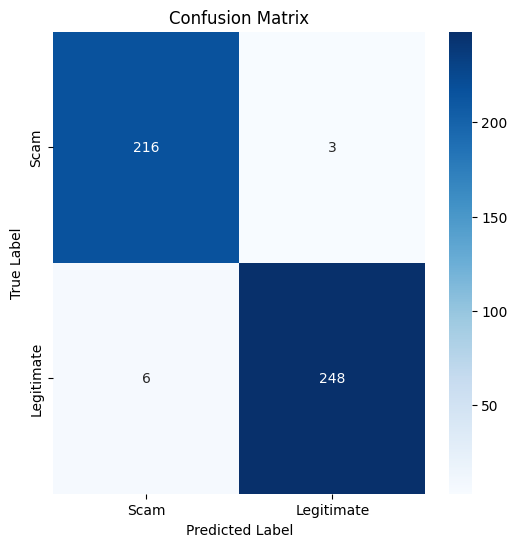

In [41]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

predictions, label_ids, metrics = trainer.predict(test_tokenized)

pred_labels = np.argmax(predictions, axis=1)
true_labels = label_ids

report = classification_report(true_labels, pred_labels, target_names=["Scam", "Legitimate"])
print(report)

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Scam", "Legitimate"], yticklabels=["Scam", "Legitimate"])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()


In [68]:
from transformers import pipeline

classifier = pipeline("text-classification", model="/content/my_awesome_model2")

# Input
text = """
Someone has contacted our dating service and entered your phone because they fancy you! To find out who it is call from a landline 09111032124 . PoBox12n146tf150p
"""

cleaned_text = clean_text(text)
result = classifier(cleaned_text)

print(result)


Device set to use cuda:0


[{'label': 'Scam', 'score': 0.9943932294845581}]
